In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import os
import numpy as np
import h5py

import matplotlib.pyplot as plt

import scipy.io
import itertools

from models.AE3D import AE3D_SEC1,AE3D,ae_loss,mse_loss
import datas.preprocess3d
from datas.Patch3DLoader import Patch3DLoader
#from datas.preprocess3d import TRAIN_AUGS_3D, TEST_AUGS_3D, TRAIN_NOAUGS_3D

class Loss_PCC(torch.nn.Module): ## works properly for isotropic 2D & if 3D it's summed over all z
    def __init__(self, eps = 1e-8, torch_device=None):
        super(Loss_PCC, self).__init__()
        self.torch_device = torch_device
        self.eps = eps

    def forward(self, img1, img2):
        tup_dim = tuple([i for i in range(2,len(img1.shape))])
        mu1 = torch.mean(img1, tup_dim)
        mu2 = torch.mean(img2, tup_dim)
        sigma1 = torch.std(img1, tup_dim)
        sigma2 = torch.std(img2, tup_dim)
        
        for i in range(2,len(img1.shape)):
            mu1 = mu1.unsqueeze(i)
            mu2 = mu2.unsqueeze(i)
            sigma1 = sigma1.unsqueeze(i)
            sigma2 = sigma2.unsqueeze(i)

        mu1 = mu1.repeat(1,1,*img1.shape[2:])
        mu2 = mu2.repeat(1,1,*img1.shape[2:])
        sigma1 = sigma1.repeat(1,1,*img1.shape[2:])
        sigma2 = sigma2.repeat(1,1,*img1.shape[2:])

        img1_ = (img1-mu1)/(sigma1+self.eps)
        img2_ = (img2-mu2)/(sigma2+self.eps)
        
        PCC = img1_*img2_
        return 1-PCC.mean()


/home/gkim/anaconda3/envs/env_clam/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '4,5,6,7'
w_mse = 0.01
w_pcc = 1.00
w_sbl = 0.01
batch_size = 24
cpus = 8
# data_path = '/data02/gkim/stem_cell_jwshin/data/230811+230502_3DH5_wider_v3_allh_onRA/' # size_z = 32 in preprocess3d 
data_path = '/data02/gkim/stem_cell_jwshin/data/23_SEC1H5_wider_v3_allh_onRA/' # size_z = 12 in preprocess3d 
epoch_max = 1500
dim_feat = 4096

epoch_load = 1499
#dir_load = '/data02/gkim/stem_cell_jwshin/outs_CLAM/AE3D_SEC1_L4096_b04_sbl2D/'

dir_save = '/data02/gkim/stem_cell_jwshin/outs_CLAM/AE3D_SEC1_L{:05d}_b{:03d}_MSE{:.3f}PCC{:.3f}SBL{:.3f}_2/'.format(dim_feat, batch_size,w_mse,w_pcc,w_sbl)

dir_load = dir_save

In [3]:
os.path.isdir(dir_save)

False

In [4]:
def save(net, epoch, path_save):
    """Save current epoch model

    Save Elements:
        model_type : arg.model
        start_epoch : current epoch
        network : network parameters
        optimizer: optimizer parameters
        best_metric : current best score

    Parameters:
        epoch : current epoch
        filename : model save file name
    """
    torch.save({"start_epoch": epoch + 1,
                "network": net.state_dict(),
                }, path_save)
    print("Model saved %d epoch" % (epoch))
    return

def load(net, path_load):
    """ Model load. same with save"""
   
    if os.path.exists(path_load) is True:
        print("Loading model from File {}".format(path_load))
        ckpoint = torch.load(path_load)

        net.load_state_dict(ckpoint['network'])
        return True
    else:
        print("Load Failed, not exists file")
        return False

In [5]:
net = AE3D_SEC1(input_channels=1, latent_dim=dim_feat)

In [6]:
from utils.loss import Loss_Sobel2d

In [12]:

torch_device = torch.device("cuda")

net = nn.DataParallel(net.to(torch_device))
#net = net.to(torch_device) # for single GPU
optimizer = optim.Adam(net.parameters(), lr=0.001)
pcc_loss = Loss_PCC(eps = 1e-6, torch_device = torch_device)
sbl_loss = Loss_Sobel2d(nn.MSELoss())

In [13]:

list_load = []
for root, _, files in os.walk(dir_load):
    for file in files:
        if file.startswith('[epoch{:04d}]'.format(epoch_load)):
            list_load.append(os.path.join(root,file))
if len(list_load) > 0:
    path_load = list_load[0]
else: path_load = 'nopath.pth.tar'
path_load

bool_load = load(net, path_load)

if not bool_load:
    epoch_load = -1


Load Failed, not exists file


In [14]:
dir_load

'/data02/gkim/stem_cell_jwshin/outs_CLAM/AE3D_SEC1_L04096_b024_MSE0.010PCC1.000SBL0.010_2/'

In [15]:
train_loader = Patch3DLoader(data_path + "/train", batch_size,
                                transform=datas.preprocess3d.TRAIN_AUGS_3D, aug_rate=0.0,
                                num_workers=cpus, shuffle=False, drop_last=False)
enum_train = itertools.cycle(train_loader)


{'00_RA_12h': 0, '00_RA_24h': 1, '02_ecto_06h': 2, '02_ecto_12h': 3, '02_ecto_24h': 4, '02_ecto_48h': 5, '02_ecto_72h': 6, '03_meso_06h': 7, '03_meso_12h': 8, '03_meso_24h': 9, '03_meso_48h': 10, '04_endo_06h': 11, '04_endo_12h': 12, '04_endo_24h': 13, '04_endo_48h': 14, '05_ctl': 15}
Dataset Dir :  /data02/gkim/stem_cell_jwshin/data/23_SEC1H5_wider_v3_allh_onRA//train len :  1990


In [16]:

for ii in range(epoch_load+1, epoch_max+1):
        #train
    net.train()
    print('starting to train epoch[%05d]' % ii)
    batch_current = 0
    for (input_, target_, path) in enum_train:
        input_, target_ = input_.to(torch_device), target_.to(torch_device)
        optimizer.zero_grad()
        recon, z = net(input_)
        mse = mse_loss(recon, input_)
        pcc = pcc_loss(recon, input_)
        sbl = sbl_loss(recon, input_)

        loss = 0.01*mse+1.0*pcc+0.01*sbl

        loss.backward()
        optimizer.step()
        batch_current = batch_current+1
        # print('\r')
        # print("training: epoch %05d batch %d/%d, pcc loss = %.3f, mse loss = %.3f"
        #       % (ii, batch_current, len(test_loader), pcc, mse))
        if batch_current == len(train_loader):
            break
        
    if ii%10 == 0:
        str_print = f"epoch number {ii}: pcc loss = {pcc}, mse loss = {mse}, sbl_loss = {sbl}"
        print(str_print)
    
    if ii%10 == 9 and ii >0:
        if not os.path.isdir(dir_save):
            os.mkdir(dir_save)
        path_save = dir_save + '[epoch{:04d}]trainloss{:.4f}.pth.tar'.format(ii, loss)
        #path_save
        save(net, ii, path_save)


starting to train epoch[00000]
epoch number 0: pcc loss = 0.37094342708587646, mse loss = 0.11033016443252563, sbl_loss = 0.021911509335041046
starting to train epoch[00001]
starting to train epoch[00002]
starting to train epoch[00003]
starting to train epoch[00004]
starting to train epoch[00005]
starting to train epoch[00006]
starting to train epoch[00007]
starting to train epoch[00008]
starting to train epoch[00009]
Model saved 9 epoch
starting to train epoch[00010]
epoch number 10: pcc loss = 0.2732027769088745, mse loss = 0.04229813441634178, sbl_loss = 0.01610339991748333
starting to train epoch[00011]
starting to train epoch[00012]
starting to train epoch[00013]
starting to train epoch[00014]
starting to train epoch[00015]
starting to train epoch[00016]
starting to train epoch[00017]
starting to train epoch[00018]
starting to train epoch[00019]
Model saved 19 epoch
starting to train epoch[00020]
epoch number 20: pcc loss = 0.22707009315490723, mse loss = 0.018636373803019524, sbl

In [17]:
# if not os.path.isdir(dir_save):
#     os.mkdir(dir_save)
# path_save = dir_save + '[epoch{:04d}]trainloss{:.4f}.pth.tar'.format(epoch, loss)
# path_save
# save(net, epoch, path_save)

In [18]:
test_loader = Patch3DLoader(data_path + "/test", 1,
                                transform=datas.preprocess3d.TEST_AUGS_3D, aug_rate=0.0,
                                num_workers=1, shuffle=False, drop_last=False)
enum_test = itertools.cycle(test_loader)

{'00_RA_12h': 0, '00_RA_24h': 1, '02_ecto_06h': 2, '02_ecto_12h': 3, '02_ecto_24h': 4, '02_ecto_48h': 5, '02_ecto_72h': 6, '03_meso_06h': 7, '03_meso_12h': 8, '03_meso_24h': 9, '03_meso_48h': 10, '04_endo_06h': 11, '04_endo_12h': 12, '04_endo_24h': 13, '04_endo_48h': 14, '05_ctl': 15}
Dataset Dir :  /data02/gkim/stem_cell_jwshin/data/23_SEC1H5_wider_v3_allh_onRA//test len :  235


In [31]:
(input_, target_, path) = next(enum_test)


input_, target_ = input_.to(torch_device), target_.to(torch_device)
optimizer.zero_grad()

recon, z = net(input_)


In [29]:
idx_batch = 0
idx_z = [2, 6, 10]

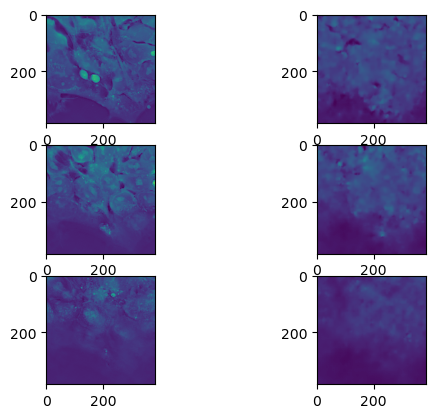

In [32]:
#np.squeeze(input_[0].detach().cpu().numpy(), axis = 0)[:,:,idx_z].shape
plt.subplot(321)
plt.imshow(np.squeeze(input_[idx_batch].detach().cpu().numpy(), axis = 0)[:,:,idx_z[0]], vmin = 0, vmax = 1)
plt.subplot(322)
plt.imshow(np.squeeze(recon[idx_batch].detach().cpu().numpy(), axis = 0)[:,:,idx_z[0]], vmin = 0, vmax = 1)
plt.subplot(323)
plt.imshow(np.squeeze(input_[idx_batch].detach().cpu().numpy(), axis = 0)[:,:,idx_z[1]], vmin = 0, vmax = 1)
plt.subplot(324)
plt.imshow(np.squeeze(recon[idx_batch].detach().cpu().numpy(), axis = 0)[:,:,idx_z[1]], vmin = 0, vmax = 1)
plt.subplot(325)
plt.imshow(np.squeeze(input_[idx_batch].detach().cpu().numpy(), axis = 0)[:,:,idx_z[2]], vmin = 0, vmax = 1)
plt.subplot(326)
plt.imshow(np.squeeze(recon[idx_batch].detach().cpu().numpy(), axis = 0)[:,:,idx_z[2]], vmin = 0, vmax = 1)